# Electric power generation time series forecasting

#### FEDOT version = 0.3.0

[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This notebook was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

Below is a case with time series forecasting using the Auto ML framework FEDOT. The possibilities of filling in gaps, out-of-sample forecasting, and using exogenous time series are shown, as well as automatic model generation (composing).  

In [106]:
# Aditional imports 
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import warnings
warnings.filterwarnings('ignore')

# fedot api
from fedot.api.main import Fedot

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# Input data for fit and predict
from fedot.core.data.data import InputData

# Train and test split 
from fedot.core.data.data import train_test_data_setup

# Data types in FEDOT
from fedot.core.repository.dataset_types import DataTypesEnum

Read dataframe

In [107]:
df = pd.read_csv('pw.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# Leave only the main variables
df = df[['datetime', 'diesel_fuel_kWh', 'wind_power_kWh']]
df.head(2)

,datetime,diesel_fuel_kWh,wind_power_kWh
0,2019-05-01,642.0,209.0
1,2019-05-02,657.0,197.0


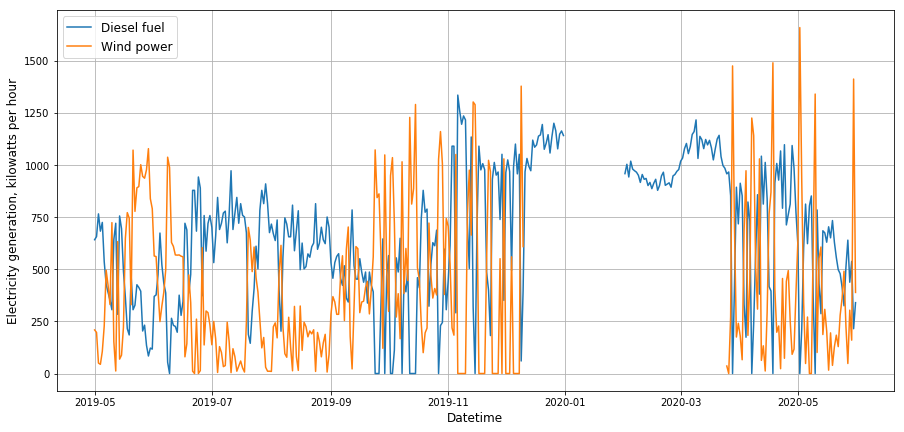

In [108]:
def plot_time_series(df):
    """ Function for visualisation """
    
    # Gap values are equal to -1.0
    diesel = np.array(df['diesel_fuel_kWh'])
    wind = np.array(df['wind_power_kWh'])
    
    # Prepare masks for gaps
    masked_diesel = np.ma.masked_where(diesel == -1.0, diesel)
    masked_wind = np.ma.masked_where(wind == -1.0, wind)
    
    plt.plot(df['datetime'], masked_diesel, label='Diesel fuel')
    plt.plot(df['datetime'], masked_wind, label='Wind power')
    plt.ylabel('Electricity generation, kilowatts per hour', fontsize=12)
    plt.xlabel('Datetime', fontsize=12)
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()

    
def plot_results(actual_time_series, predicted_values, len_train_data, y_name='Parameter'):
    """
    Function for drawing plot with predictions

    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """

    plt.plot(np.arange(0, len(actual_time_series)),
             actual_time_series, label='Actual values', c='green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)),
             predicted_values, label='Predicted', c='blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c='black', linewidth=1)
    plt.ylabel(y_name, fontsize=15)
    plt.xlabel('Time index', fontsize=15)
    plt.legend(fontsize=15, loc='upper left')
    plt.grid()
    plt.show()
    

plot_time_series(df)

There are 2 time series: first is the average daily electricity generation of a wind farm (measured in kilowatts per hour). Another time series is the generation of electricity using a diesel generator (wind power).

The operation of a wind power generator depends on the strength of the wind, and when it dies down, a diesel generator is used to maintain electricity generation at a sufficient level. Hence, the behavior of time series can be traced - when the electricity generation on a wind turbine falls, it increases on a diesel generator, and vice versa. It is also worth noting that the time series has gaps.

Task: prepare a model for forecasting 14 elements ahead (for diesel_fuel_kWh (blue curve) time series)

## Time series gap-filling

The first problem we encountered was the presence of omissions. In FEDOT, 2 groups of methods are used to restore values in time series:
* Simple methods such as linear interpolation and Savitsky-Goley filters;
* Methods based on the composite models of the framework (advanced gap-filling).

In [41]:
from fedot.utilities.ts_gapfilling import ModelGapFiller

# Composite models in FEDOT
from fedot.core.chains.chain import Chain
from fedot.core.chains.node import PrimaryNode, SecondaryNode

### Diesel fuel series reconstruction 

Below, we will use FEDOT time series forecasting models to fill in the gaps.

In [58]:
diesel = np.array(df['diesel_fuel_kWh'])

# Advanced gap-filling
node_smoothing = PrimaryNode('gaussian_filter')
node_smoothing.custom_params = {'sigma': 2}

node_lagged = SecondaryNode('lagged', nodes_from=[node_smoothing])
node_lagged.custom_params = {'window_size': 30}

node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged])
chain = Chain(node_ridge) 
    
model_gapfiller = ModelGapFiller(gap_value=-1.0,
                                 chain=chain)

# Filling in the gaps
without_gap_bidirect = model_gapfiller.forward_inverse_filling(diesel)

Fit chain from scratch
Fit chain from scratch


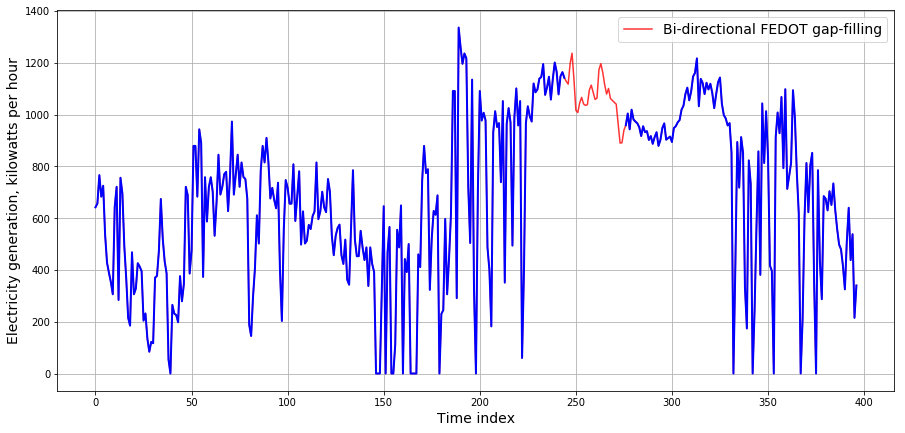

In [59]:
masked_array = np.ma.masked_where(diesel == -1.0, diesel)
plt.plot(without_gap_bidirect, c='red', alpha=0.8, label='Bi-directional FEDOT gap-filling')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel('Electricity generation, kilowatts per hour', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Wind power generator series reconstruction 

Now fill in the gaps in the time series with the values of the wind power generator output. For this purpose, we will collate the values of two time series and solve the pair regression problem

In [70]:
wind = np.array(df['wind_power_kWh'])
# Find ids where the gaps are located
ids_gaps = np.ravel(np.argwhere(wind == -1.0))
ids_non_gaps = np.ravel(np.argwhere(wind != -1.0))

# Features with and without gaps
train_x = without_gap_bidirect[ids_non_gaps].reshape((-1, 1))
predict_x = without_gap_bidirect[ids_gaps].reshape((-1, 1))

# Prepare target for training
train_target = wind[ids_non_gaps].reshape((-1, 1))

Let's run the compositing algorithm via the API

In [71]:
# Task selection, initialisation of the framework
fedot_model = Fedot(problem='regression', learning_time=5)

# During fit, the chain composition algorithm is started
pipeline = fedot_model.fit(features=train_x,
                           target=train_target)

Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'knnreg', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'one_hot_encoding', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg']. Composing time limit: 5 min
Model composition started
Hyperparameters tuning started
Default loss function was set
Hyperparameters optimization start
 82%|████████████████████████████████████▉        | 822/1000 [02:30<00:32,  5.47trial/s, best loss: 210.06967349510677]
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 210.070 equal or smaller than initial (+ 5% deviation) 255.821
Model composition finished


Create visualization for obtained pipeline 

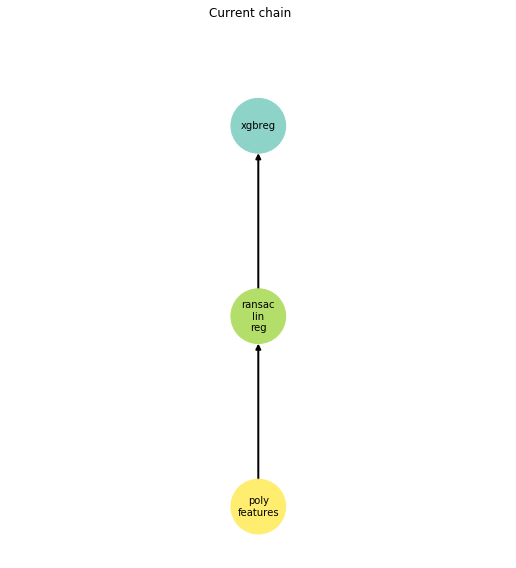

In [74]:
pipeline.show()

So, there were 3 nodes in the obtained chain:
1) poly_features - polynomial feature generator;
2) ransac_lin_reg - RANSAC (RANdom SAmple Consensus) algorithm with linear regression as base estimator. Removing outliers;
3) xgbreg - XGBoost regression model.

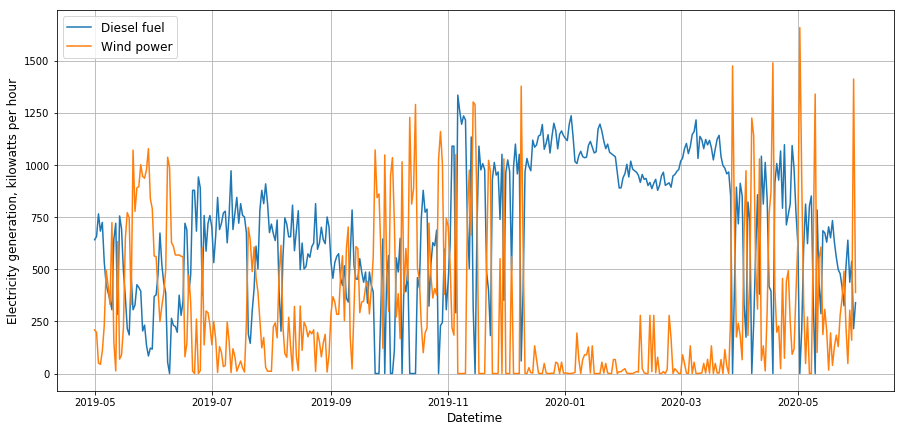

In [80]:
# Make prediction 
prediction = fedot_model.predict(features=predict_x)

# Prediction can't be lower than zero 
prediction[prediction < 0] = 0.0

# Imputation 
wind_without_gaps = np.copy(wind)
wind_without_gaps[ids_gaps] = prediction

# Create new dataframe with time series without gaps
df_filled = pd.DataFrame({'datetime': df['datetime'], 
                          'diesel_fuel_kWh': without_gap_bidirect,
                          'wind_power_kWh': wind_without_gaps})

# Plot reconstructed time series
plot_time_series(df_filled)

In [82]:
# Save dataframe
df_filled.to_csv('pw_filled.csv', index=False)

## Simple time series forecasting

### API-based composing 

Both time series have been restored, so let's try to build the first forecasting model. Let's try to predict the behavior of the "Diesel fuel" series based on historical data. 

In [7]:
df_filled = pd.read_csv('pw_filled.csv')

# Define forecast length
forecast_length = 14

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))

# Get time series from dataframe
disel = np.array(df_filled['diesel_fuel_kWh'])
input_data = InputData(idx=np.arange(0, len(disel)),
                       features=disel,
                       target=disel,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Split data into train and test
train_input, predict_input = train_test_data_setup(input_data)

task_parameters = TsForecastingParams(forecast_length=forecast_length)

We use the API and start composing the chain

In [107]:
model = Fedot(problem='ts_forecasting',
              task_params=task_parameters)

# Run AutoML model design in the same way
obtained_chain = model.fit(features=train_input)

# Use model to obtain forecast
forecast = model.predict(features=predict_input)

Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'ar', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 2 min
Model composition started
Hyperparameters tuning started
Default loss function was set
Hyperparameters optimization start
100%|████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.42trial/s, best loss: 206.40179629731983]
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 206.402 equal or smaller than initial (+ 5% deviation) 263.259
Model composition finished


Chain visualization

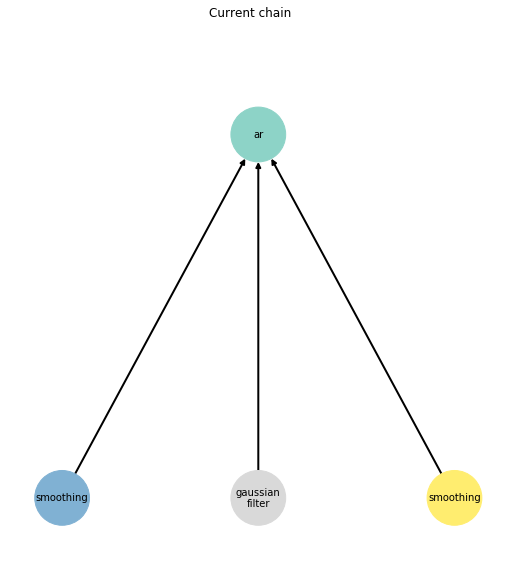

In [108]:
obtained_chain.show()

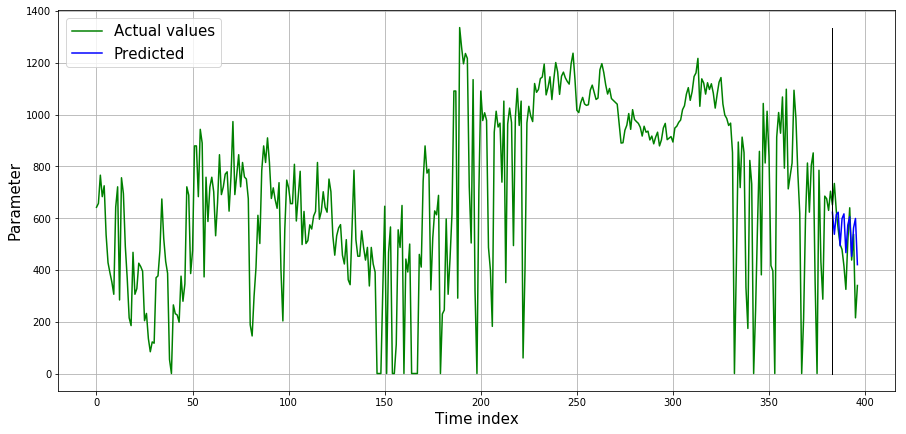

MAE - 98.34
RMSE - 19913.70


In [110]:
# Plot results
plot_results(actual_time_series=disel,
             predicted_values=forecast,
             len_train_data=len(disel) - forecast_length)

mse_metric = mean_squared_error(predict_input.target, forecast)
mae_metric = mean_absolute_error(predict_input.target, forecast)

print(f'MAE - {mae_metric:.2f}')
print(f'RMSE - {mse_metric:.2f}')

We calculated the error metrics on a section of the time series equal to the forecast horizon. But it is better to perform validation using an "in-sample" forecast on several such blocks, for example, on 3. Let's do this

In [89]:
from fedot.core.chains.chain_ts_wrappers import in_sample_ts_forecast

def validation(chain, predict_input, forecast_length, validation_blocks,
               source_time_series):
    """ Function for validation time series forecasts on several blocks
    
    :param chain: fitted Chain object  
    :param predict_input: InputData for prediction 
    :param forecast_length: forecast length
    :param validation_blocks: amount of blocks for validation
    :param source_time_series: array with time series
    """
    
    # Make in-sample prediction
    horizon = 14 * validation_blocks
    predicted_values = in_sample_ts_forecast(chain=chain,
                                             input_data=predict_input,
                                             horizon=horizon)
    
    actual_values = np.ravel(source_time_series[-horizon:])
    pre_history = np.ravel(source_time_series[:-horizon])
    mse_metric = mean_squared_error(actual_values, predicted_values)
    mae_metric = mean_absolute_error(actual_values, predicted_values)

    print(f'MAE - {mae_metric:.2f}')
    print(f'RMSE - {mse_metric:.2f}')
    
    # Plot time series forecasted 
    plt.plot(range(0, len(source_time_series)), source_time_series, c='green', label='Actual time series')
    plt.plot(range(len(pre_history), len(source_time_series)), predicted_values, c='blue', label='Forecast')
    
    i = len(pre_history)
    for _ in range(0, validation_blocks):
        deviation = np.std(predicted_values)
        plt.plot([i, i], [min(actual_values)-deviation, max(actual_values)+deviation],
                 c='black', linewidth=1)
        i += forecast_length

    plt.legend(fontsize=15)
    start_view_point = len(source_time_series) - horizon - 50
    plt.xlim(start_view_point, len(source_time_series))
    plt.xlabel('Time index', fontsize=15)
    plt.show()

In [90]:
# We will use 3 blocks for validation 
input_data = InputData(idx=np.arange(0, len(disel)),
                       features=disel,
                       target=disel,
                       task=task,
                       data_type=DataTypesEnum.ts)

# The data on which we will perform validation, the model should not have been 
# used during training
validation_blocks = 3
horizon = forecast_length*validation_blocks

# Divide into train and test 
train_part = disel[:-horizon]

# InputData for train 
train_input = InputData(idx=range(0, len(train_part)),
                        features=train_part,
                        target=train_part,
                        task=task,
                        data_type=DataTypesEnum.ts)

# InputData for validation  
validation_input = InputData(idx=range(0, len(disel)),
                             features=disel,
                             target=disel,
                             task=task,
                             data_type=DataTypesEnum.ts)

In [91]:
model = Fedot(problem='ts_forecasting',
              task_params=task_parameters, 
              learning_time=5)

# Run AutoML model design in the same way
obtained_chain = model.fit(features=train_input)

Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'ar', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 5 min
Model composition started
Metric evaluation error: Found input variables with inconsistent numbers of samples: [14, 317]
Hyperparameters tuning started
Default loss function was set
Hyperparameters optimization start
100%|█████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.06trial/s, best loss: 330.3192290076282]
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 330.319 equal or smaller than initial (+ 5% deviation) 347.013
Model composition finished


MAE - 214.36
RMSE - 74842.40


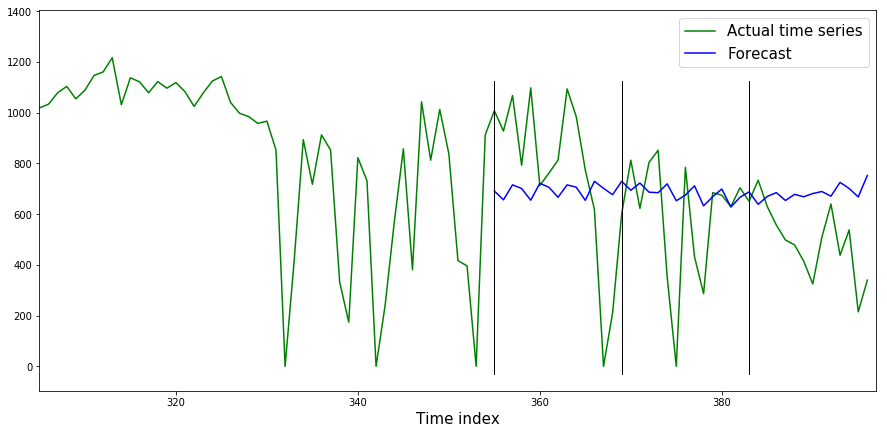

In [92]:
# Perform validation 
validation(obtained_chain, validation_input,
           forecast_length=forecast_length, 
           validation_blocks=validation_blocks,
           source_time_series=disel)

So, we have achieved the accuracy by the MAE - 214.36.

### Advanced core-based composing

Below, we will try to build a forecast using advanced composting methods based on FEDOT's internal methods.

In [57]:
import datetime

# Import fedot composer and supplementary classes 
from fedot.core.composer.gp_composer.gp_composer import \
    GPComposerBuilder, GPComposerRequirements
from fedot.core.composer.optimisers.gp_comp.gp_optimiser import GPChainOptimiserParameters
from fedot.core.composer.optimisers.gp_comp.operators.mutation import MutationTypesEnum
from fedot.core.composer.visualisation import ChainVisualiser
from fedot.core.repository.quality_metrics_repository import \
    MetricsRepository, RegressionMetricsEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

In [58]:
primary_operations = ['lagged', 'smoothing', 'gaussian_filter', 'ar']
secondary_operations = ['lagged', 'ridge', 'lasso', 'knnreg', 'dtreg', 
                        'linear', 'scaling', 'ransac_lin_reg', 'ransac_non_lin_reg', 
                        'rfe_lin_reg', 'rfe_non_lin_reg']

# Composer parameters
composer_requirements = GPComposerRequirements(
    primary=primary_operations,
    secondary=secondary_operations, max_arity=3,
    max_depth=8, pop_size=10, num_of_generations=30,
    crossover_prob=0.8, mutation_prob=0.8,
    max_lead_time=datetime.timedelta(minutes=10),
    allow_single_operations=False)

*Due to the specifics of the jupiter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

In [ ]:
mutation_types = [MutationTypesEnum.parameter_change, MutationTypesEnum.simple, MutationTypesEnum.reduce]
optimiser_parameters = GPChainOptimiserParameters(mutation_types=mutation_types)

node_lagged = PrimaryNode('lagged')
node_lagged.custom_params = {'window_size': 30}

node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged])
init_chain = Chain(node_ridge) 

metric_function = MetricsRepository().metric_by_id(RegressionMetricsEnum.MAE)
builder = GPComposerBuilder(task=task). \
    with_optimiser_parameters(optimiser_parameters).\
    with_requirements(composer_requirements).\
    with_metrics(metric_function).with_initial_chain(init_chain)
composer = builder.build()

obtained_chain = composer.compose_chain(data=train_input, is_visualise=False)

# Start tuning all nodes in the chain 
tuned_chain = obtained_chain.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                                 loss_params=None,
                                                 input_data=train_input,
                                                 iterations=200)

MAE - 88.19
RMSE - 31438.75


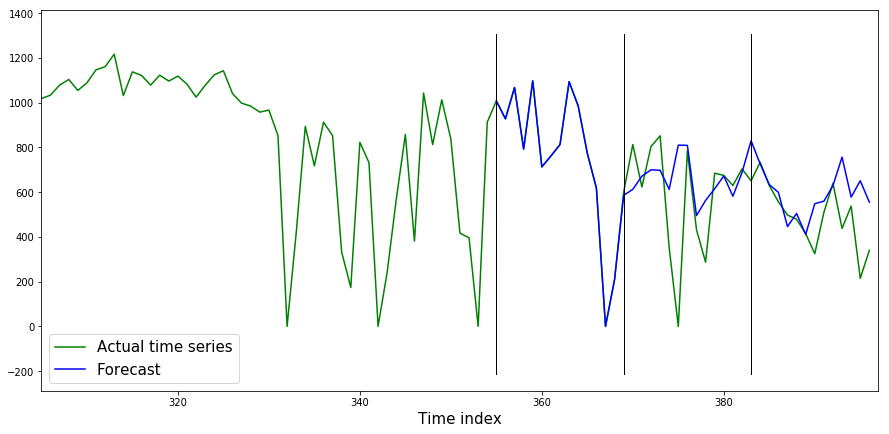

In [119]:
# Perform validation 
validation(tuned_chain, validation_input,
           forecast_length=forecast_length, 
           validation_blocks=validation_blocks,
           source_time_series=disel)

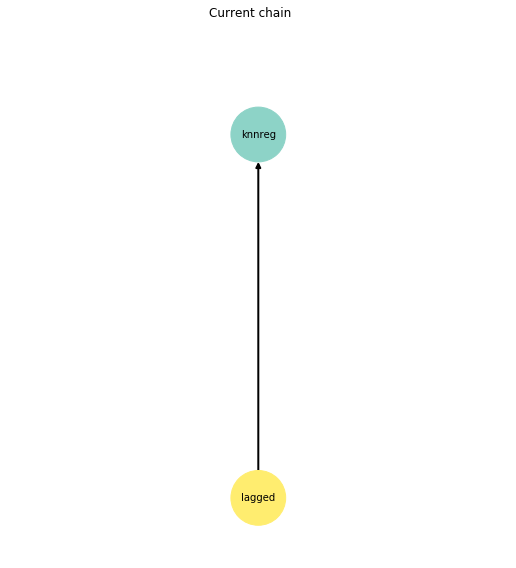

In [64]:
tuned_chain.show()

Great, we've already made improvements in metrics!

## Forecasting time series with exogenous variables

-> ПРЕДЛАГАЮ УДАЛИТЬ ЭТОТ РАЗДЕЛ

In [102]:
df_filled = pd.read_csv('pw_filled.csv')

# Get time series from dataframe
disel = np.array(df_filled['diesel_fuel_kWh'])
wind = np.array(df_filled['wind_power_kWh'])

# Prepare train and predict inputs for disel time series
train_disel = disel[:-forecast_length]
test_disel = disel[-forecast_length:]

# Specify task
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))

train_input_disel = InputData(idx=np.arange(0, len(train_disel)),
                              features=train_disel,
                              target=train_disel,
                              task=task,
                              data_type=DataTypesEnum.ts)

start_forecast = len(test_disel)
end_forecast = start_forecast + forecast_length 
predict_input_disel = InputData(idx=np.arange(start_forecast, end_forecast),
                                features=train_disel,
                                target=test_disel,
                                task=task,
                                data_type=DataTypesEnum.ts)

In [103]:
# Prepare train and predict inputs for disel time series
train_wind = wind[:-forecast_length]
test_wind = wind[-forecast_length:]

train_input_wind = InputData(idx=np.arange(0, len(train_wind)),
                             features=train_wind,
                             target=train_wind,
                             task=task,
                             data_type=DataTypesEnum.ts)

predict_input_wind = InputData(idx=np.arange(start_forecast, end_forecast),
                               features=train_wind,
                               target=test_wind,
                               task=task,
                               data_type=DataTypesEnum.ts)

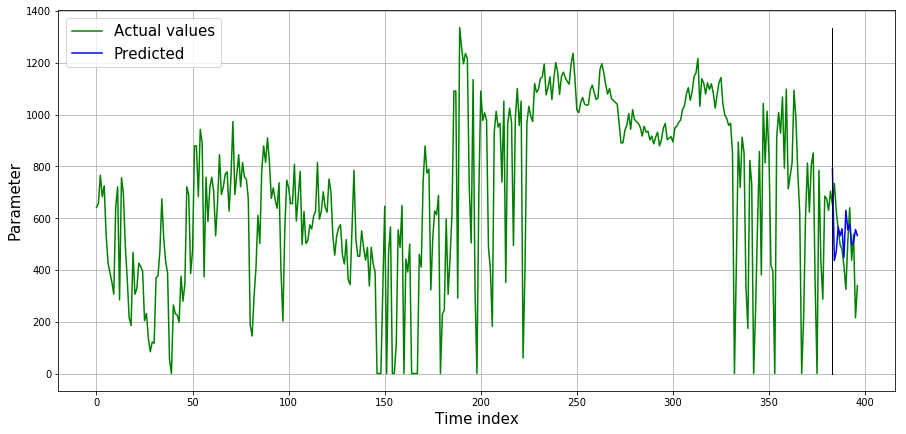

MAE - 128.01
RMSE - 28538.95


In [133]:
# Create a chain with different data sources in th nodes 
node_disel = PrimaryNode('lagged', node_data={'fit': train_input_disel,
                                              'predict': predict_input_disel})
node_disel.custom_params = {'window_size': 2}
node_wind = PrimaryNode('lagged', node_data={'fit': train_input_wind,
                                             'predict': predict_input_wind})
node_wind.custom_params = {'window_size': 11}
node_ridge = SecondaryNode('linear', nodes_from=[node_disel, node_wind])
exog_chain = Chain(node_ridge)

# Fit it
exog_chain.fit()

# Predict
predicted = exog_chain.predict()
forecast = np.ravel(np.array(predicted.predict))

# Plot results
plot_results(actual_time_series=disel,
             predicted_values=forecast,
             len_train_data=len(disel) - forecast_length)

mse_metric = mean_squared_error(predict_input.target, forecast)
mae_metric = mean_absolute_error(predict_input.target, forecast)

print(f'MAE - {mae_metric:.2f}')
print(f'RMSE - {mse_metric:.2f}')